In [30]:
import utils
from regions.selectivesearch_answer import selective_search
# from regions.selectivesearch import selective_search

# from nms import non_max_supression_slow as nms
from nms import non_max_supression_with_scores as nms
from nms import get_iou

import chainer
from chainercv.links import FeaturePredictor
from chainercv.links import VGG16

%matplotlib inline 

In [31]:
##############
# PARAMETERS #
##############

# DIRECTORY
DIR = '/data/unagi0/ilsvrc2017/ILSVRC/'

# MODEL PATH ON SERVER
# IF YOU ARE RUNNING LOCALLY YOU MUST EDIT THIS PATH!
MODEL_PATH = '/data/unagi0/dataset/rinkou/vgg16_imagenet_convert_2017_07_18.npz'

# GPU (-1 if performing on CPU)
GPU = -1

# IMAGE SELECTION PARAMETERS
RANDOM_SEED = 200
NUMBER_OF_IMAGES = 1

# SELECTIVE-SEARCH PARAMETERS
SS_PARAMS = {"SCALE": 250,
            "SIGMA": 0.9,
            "MIN_SIZE": 50,
            "MIN_REGION": 2000,
            "MAX_RATIO": 2}

# NMS PARAMETERS
IOU_THRESHOLD = 0.3

# DISPLAY DETECTED REGIONS WITH CONFIDENCE ABOVE
CONF_THRESHOLD = 0.5

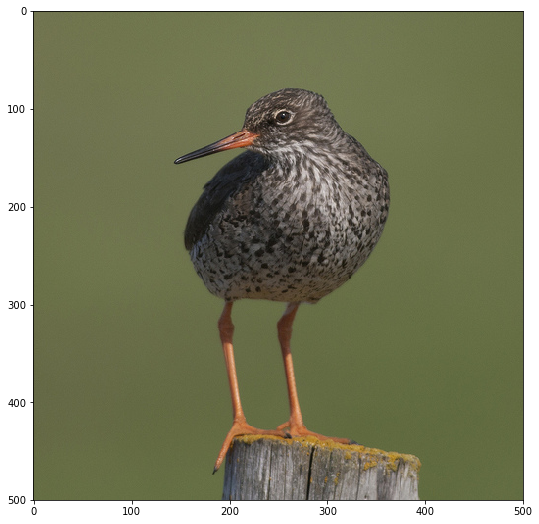

In [32]:
# Get image filenames from val.txt image set
# image_paths = utils.random_image_set(RANDOM_SEED, DIR, NUMBER_OF_IMAGES)

# local Images
image_paths = ['./test_images/ILSVRC2012_val_00033333.JPEG', './test_images/ILSVRC2012_val_00022529.JPEG', './test_images/ILSVRC2013_val_00000663.JPEG', './test_images/ILSVRC2012_val_00020569.JPEG', './test_images/ILSVRC2012_val_00042005.JPEG']

image_paths = image_paths[:NUMBER_OF_IMAGES]

# Load and Display images
imgs = utils.get_images(image_paths, display=True)

# Each image in imgs is intialized as a dictionary:
# imgs.append({"original": img,
#               "cropped_regions": [],
#               "bboxes": [],
#               "classes": [],
#               "confidences": [],
#               "area": area})

CPU times: user 1.41 s, sys: 24.1 ms, total: 1.43 s
Wall time: 1.43 s


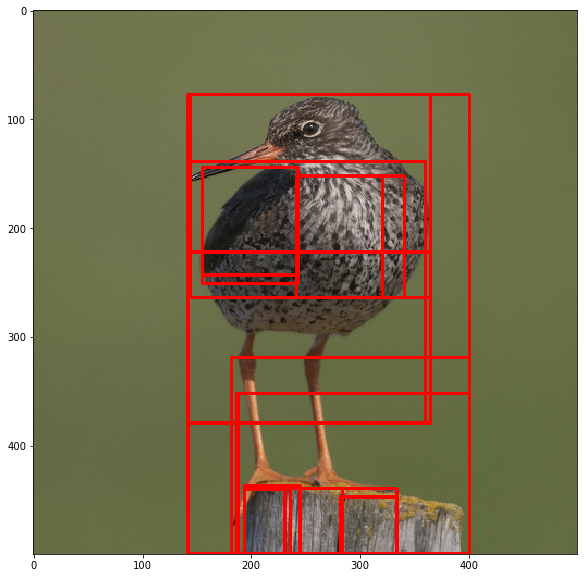

In [33]:
%%time
# Performs selective search using function "selective_search"
# perform_selectivesearch appends bboxes to img["bboxes"] and cropped regions to img["cropped_regions"]
utils.perform_selectivesearch(selective_search, imgs, SS_PARAMS)

In [34]:
# Initialize VGG16 classifier model
extractor = VGG16(1000, MODEL_PATH)
model = FeaturePredictor(extractor, crop_size=224, scale_size=256, crop='center')
if GPU >= 0:
    chainer.cuda.get_device(GPU).use()
    model.to_gpu()

In [35]:
%%time
# perform_classification appends class predictions to img["classes"] and confidences to img["confidences"]
utils.perform_classification(model, imgs)

CPU times: user 1min 3s, sys: 4.63 s, total: 1min 7s
Wall time: 12 s


In [36]:
%%time
# Perform non maximum supression on bounding boxes. For regions havin an overlap exceeding the threshold
# The region with the lower confidence score will be suppressed
for img in imgs:
    img["selected_regions"] = nms(img["bboxes"], img["confidences"], IOU_THRESHOLD)

TESTAROO
CPU times: user 18.7 ms, sys: 360 µs, total: 19 ms
Wall time: 1.19 ms


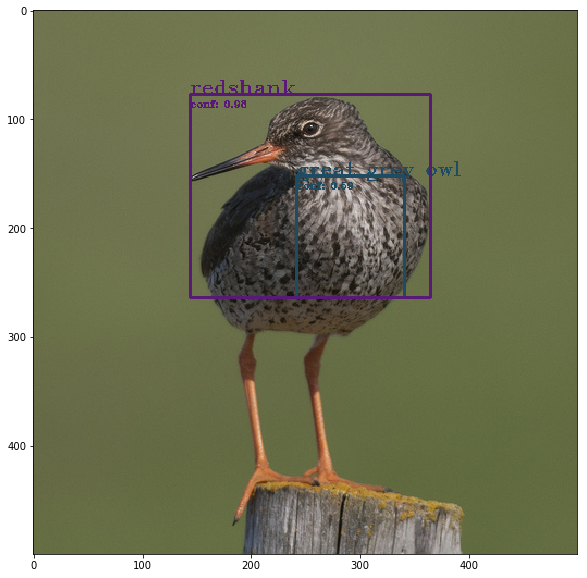

In [37]:
# Display Detected Regions and Classes
utils.display_detections(imgs, CONF_THRESHOLD)